In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector, SequentialFeatureSelector


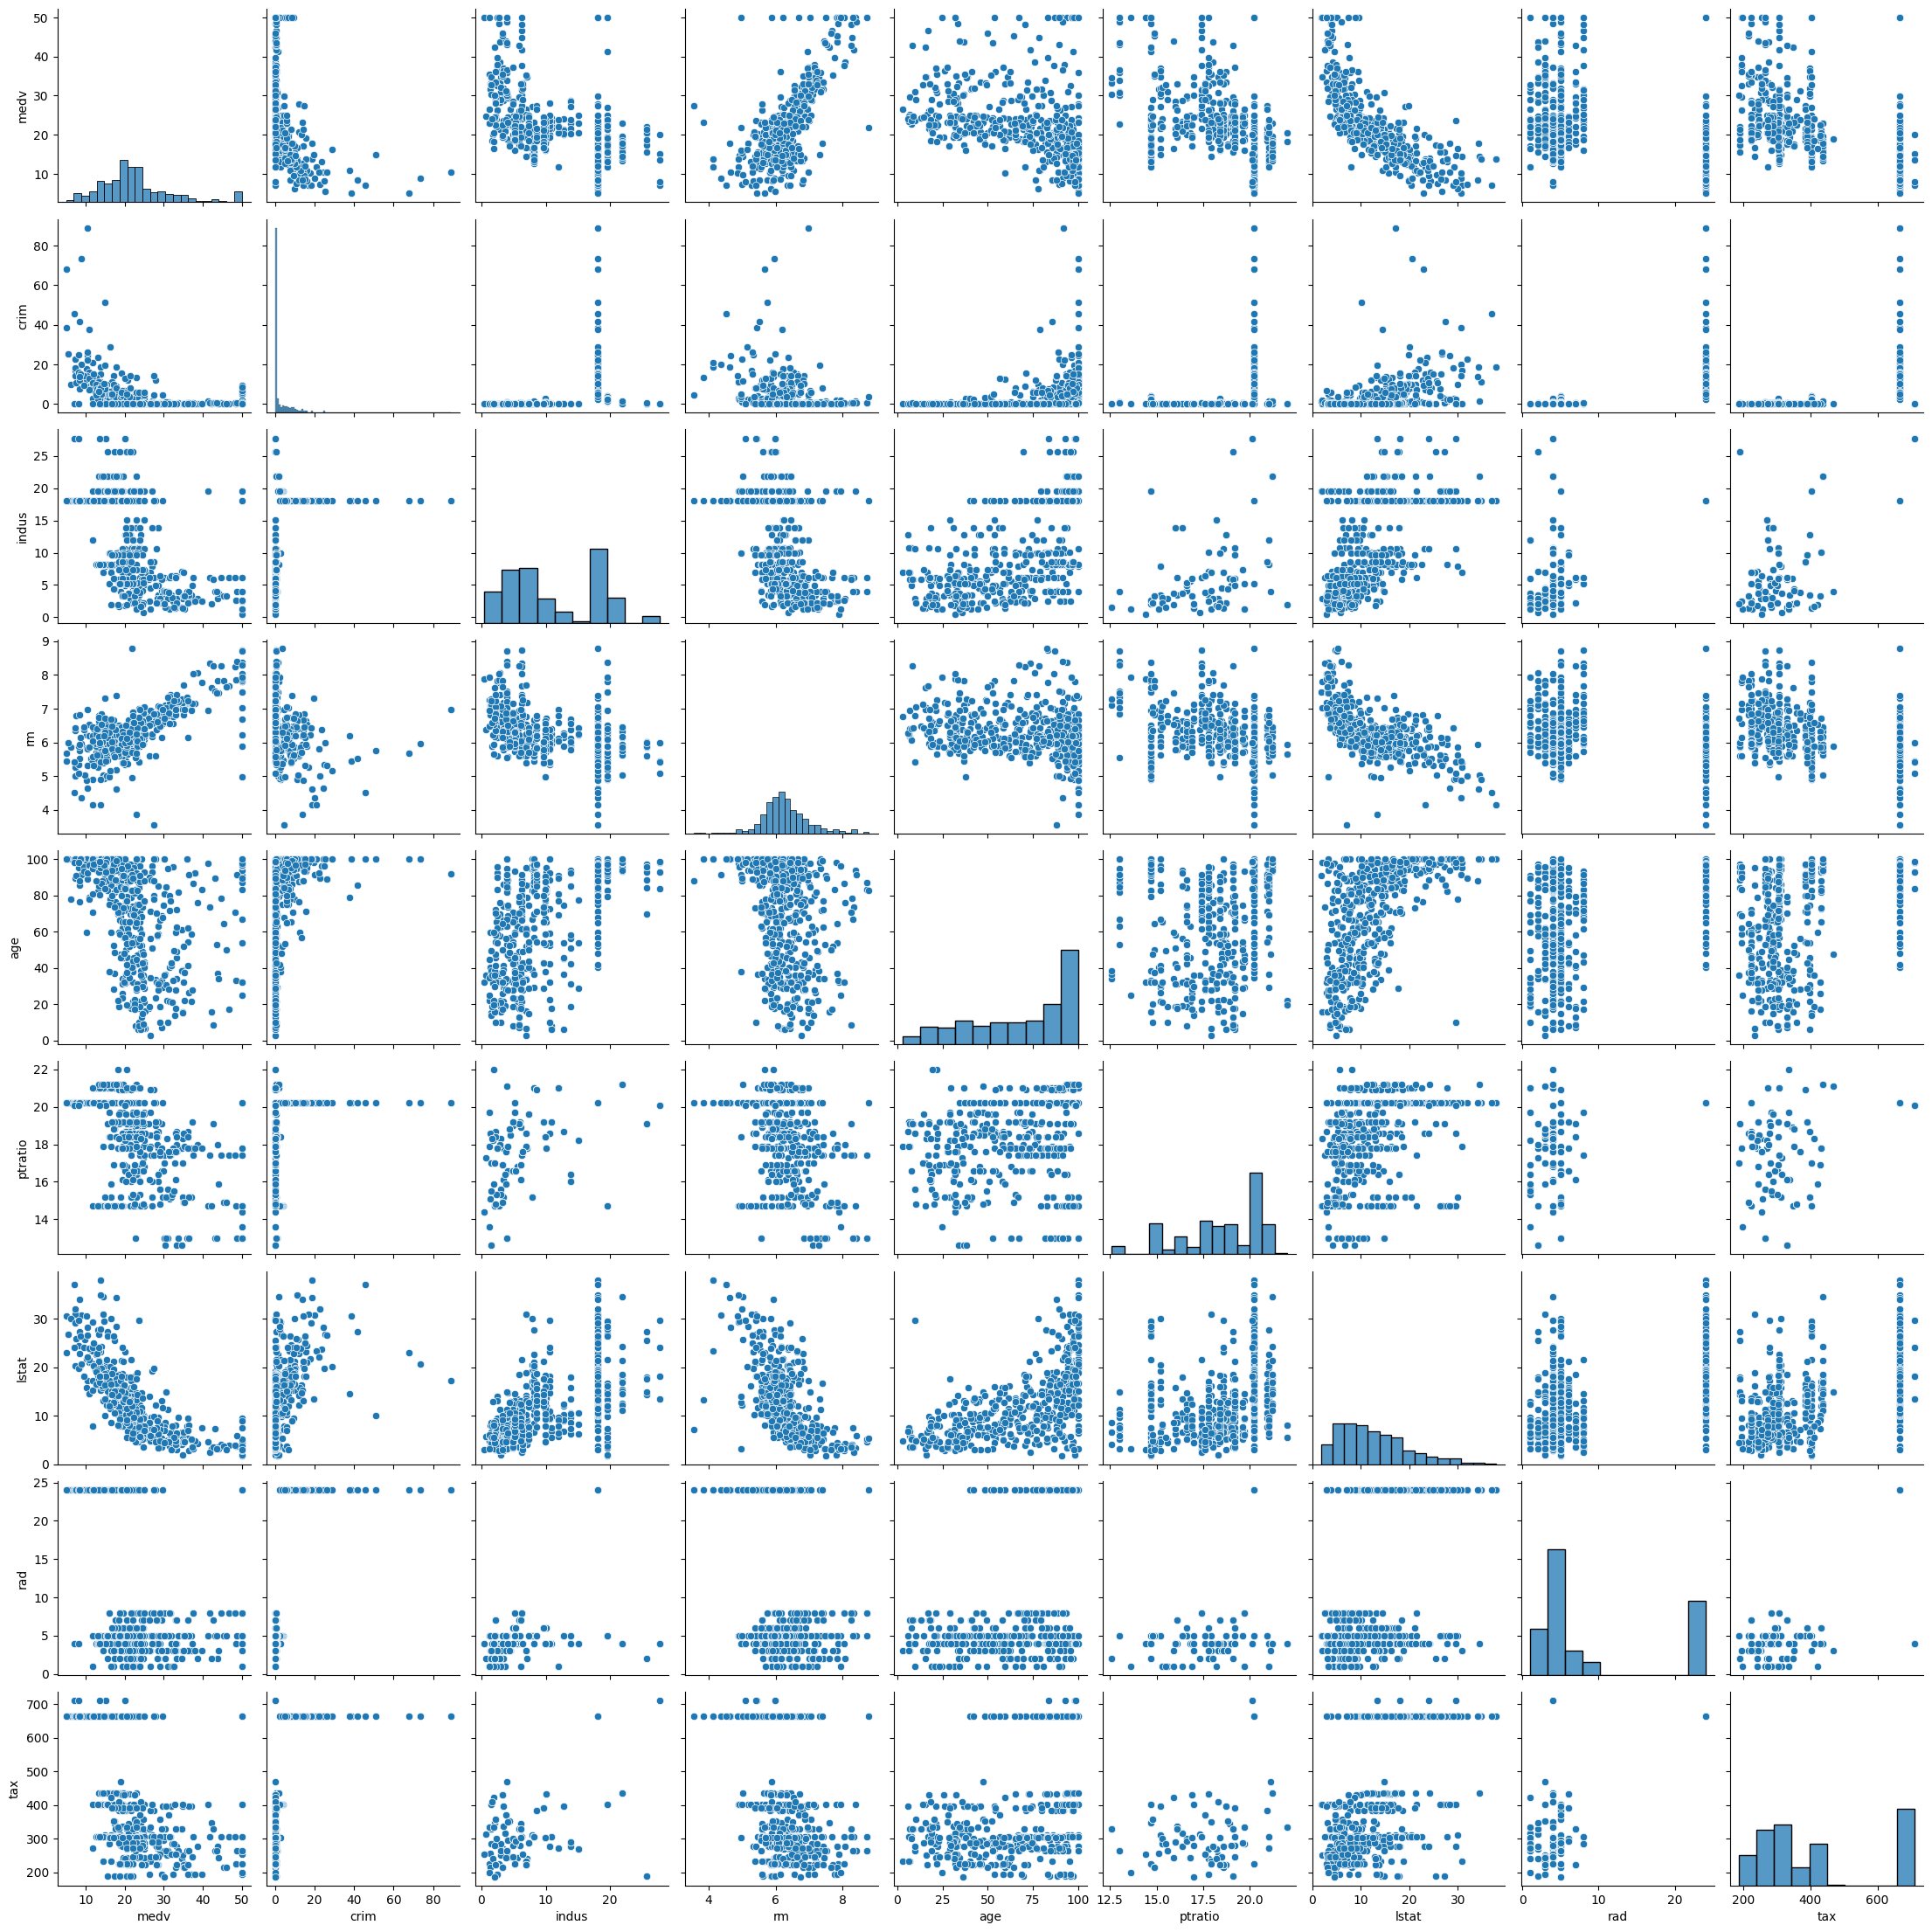

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     140.9
Date:                Sat, 06 Sep 2025   Prob (F-statistic):          1.45e-122
Time:                        21:36:33   Log-Likelihood:                -1540.7
No. Observations:                 506   AIC:                             3099.
Df Residuals:                     497   BIC:                             3137.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.0272      4.201      5.482      0.0

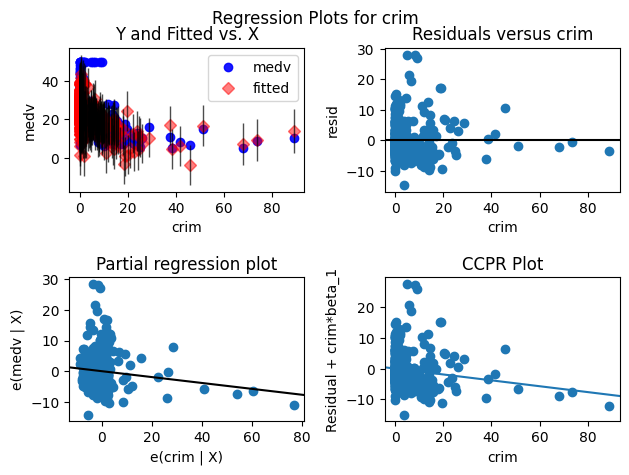

Outliers: 25
Leverage points: 33
Influential points: 32


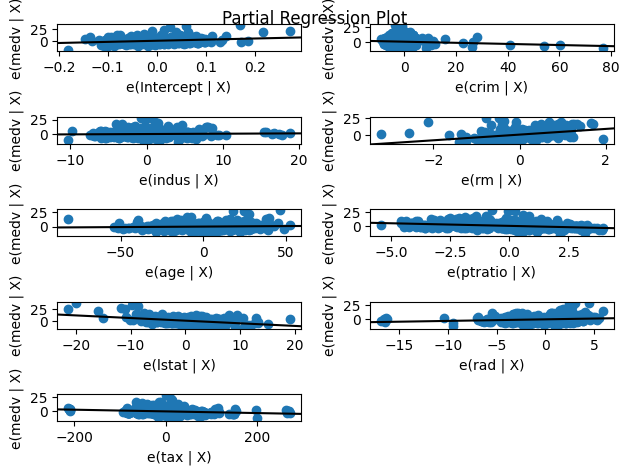

   feature         VIF
0    const  339.459353
1     crim    1.733962
2    indus    3.001185
3       rm    1.844176
4      age    2.080959
5  ptratio    1.406373
6    lstat    2.826137
7      rad    6.993142
8      tax    8.286915


In [3]:

# --------------------------
# Setup
# --------------------------

housing = pd.read_csv("housing.csv")
pgatour2006 = pd.read_csv("pgatour2006.csv")

# --------------------------
# Question 1
# --------------------------

# a. Pairplot
sns.pairplot(housing)
plt.show()

# b. Full model
m1 = smf.ols("medv ~ " + " + ".join(housing.columns.drop("medv")), data=housing).fit()
print(m1.summary())

sm.graphics.plot_regress_exog(m1, "crim")
plt.show()

# c. Outliers / leverage / influence
n = housing.shape[0]
p = len(m1.params) - 1

outliers = np.sum(np.abs(m1.get_influence().resid_studentized_internal) > 2)
leverage = np.sum(m1.get_influence().hat_matrix_diag > (2 * (p+1) / n))
influential = np.sum(m1.get_influence().cooks_distance[0] > 4 / (n-2))

print("Outliers:", outliers)
print("Leverage points:", leverage)
print("Influential points:", influential)

# d. Added-variable plots (partial regression plots)
sm.graphics.plot_partregress_grid(m1)
plt.show()

# e. VIF
X = housing.drop(columns=["medv"])
X_const = sm.add_constant(X)
vif_data = pd.DataFrame({
    "feature": X_const.columns,
    "VIF": [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})
print(vif_data)


                            OLS Regression Results                            
Dep. Variable:               logPrize   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     33.87
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           3.18e-30
Time:                        21:39:12   Log-Likelihood:                -193.74
No. Observations:                 196   AIC:                             403.5
Df Residuals:                     188   BIC:                             429.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1943      7.777  

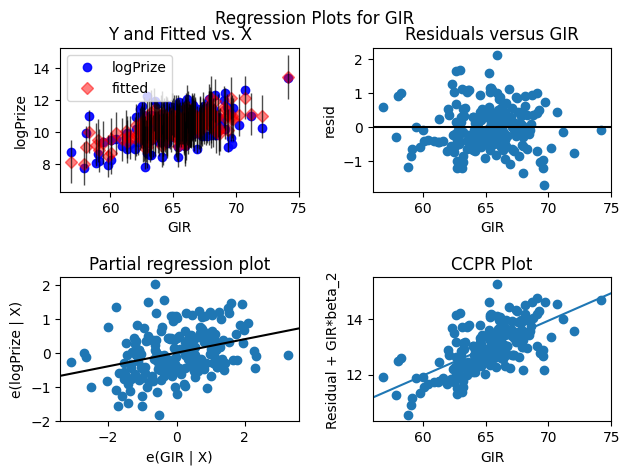

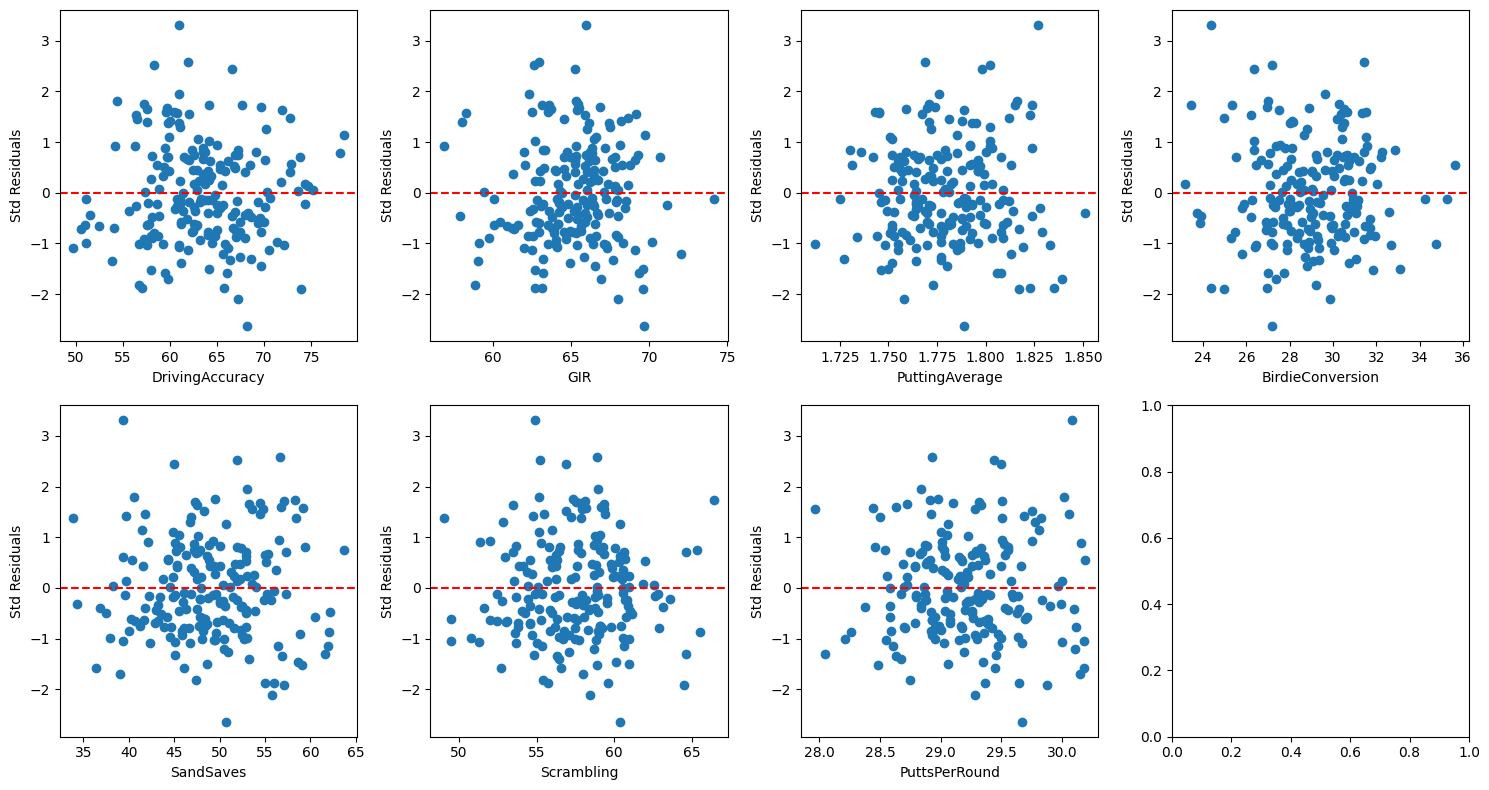

Outliers: [  8  46  62 121 179 184]
Leverage: [ 15  39  69  76 167 177]
Influential: [  0  39  46  59  62  83 100 121 124 127 167 184]
            feature           VIF
0             const  26895.428687
1   DrivingAccuracy      1.796616
2               GIR      6.294969
3    PuttingAverage     12.900789
4  BirdieConversion      3.511898
5         SandSaves      1.461506
6        Scrambling      4.470203
7     PuttsPerRound     19.355667


In [9]:
# --------------------------
# Question 2
# --------------------------

# Make sure column names are clean (remove spaces if any)
pgatour2006.columns = pgatour2006.columns.str.replace(" ", "")

# Create log-transformed PrizeMoney
pgatour2006["logPrize"] = np.log(pgatour2006["PrizeMoney"])

# a. Fit model on PGA data
m2 = smf.ols("logPrize ~ DrivingAccuracy + GIR + PuttingAverage + "
             "BirdieConversion + SandSaves + Scrambling + PuttsPerRound", 
             data=pgatour2006).fit()
print(m2.summary())

# Regression diagnostic for GIR
sm.graphics.plot_regress_exog(m2, "GIR")
plt.show()

# b. Residual plots
stanres = m2.get_influence().resid_studentized_internal
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
predictors = ["DrivingAccuracy", "GIR", "PuttingAverage", "BirdieConversion",
              "SandSaves", "Scrambling", "PuttsPerRound"]

for ax, var in zip(axes.flatten(), predictors):
    ax.scatter(pgatour2006[var], stanres)
    ax.axhline(0, color="red", linestyle="--")
    ax.set_xlabel(var)
    ax.set_ylabel("Std Residuals")

plt.tight_layout()
plt.show()

# c. Outlier / leverage / influence for m2
n2 = pgatour2006.shape[0]
p2 = len(m2.params) - 1

outliers2 = np.where(np.abs(m2.get_influence().resid_studentized_internal) > 2)[0]
leverage2 = np.where(m2.get_influence().hat_matrix_diag > (2 * (p2+1) / n2))[0]
influential2 = np.where(m2.get_influence().cooks_distance[0] > 4 / (n2-2))[0]

print("Outliers:", outliers2)
print("Leverage:", leverage2)
print("Influential:", influential2)

# d. Model summary already shown above

# e. VIF for m2
X2 = pgatour2006[["DrivingAccuracy", "GIR", "PuttingAverage", 
                  "BirdieConversion", "SandSaves", "Scrambling", 
                  "PuttsPerRound"]]
X2_const = sm.add_constant(X2)
vif_m2 = pd.DataFrame({
    "feature": X2_const.columns,
    "VIF": [variance_inflation_factor(X2_const.values, i)
            for i in range(X2_const.shape[1])]
})
print(vif_m2)

In [10]:

# --------------------------
# Question 3
# --------------------------

y = np.log(pgatour2006["PrizeMoney"])
X3 = X2

# a. Exhaustive search (like regsubsets in R)
linreg = LinearRegression()
efs = ExhaustiveFeatureSelector(linreg, 
                                min_features=1, 
                                max_features=7,
                                scoring='r2',
                                cv=5)
efs.fit(X3, y)
print("Best subset (adj R^2 proxy):", efs.best_idx_)

# b. Backward stepwise selection (AIC ~ stepAIC in R)
# statsmodels doesn’t have stepAIC; mimic with BIC / AIC selection
sfs_backward_aic = SequentialFeatureSelector(linreg,
                                             k_features="best",
                                             forward=False,
                                             floating=False,
                                             scoring="neg_mean_squared_error",
                                             cv=5)
sfs_backward_aic.fit(X3, y)
print("Backward AIC-like subset:", sfs_backward_aic.k_feature_idx_)

sfs_backward_bic = SequentialFeatureSelector(linreg,
                                             k_features="best",
                                             forward=False,
                                             floating=False,
                                             scoring="r2",
                                             cv=5)
sfs_backward_bic.fit(X3, y)
print("Backward BIC-like subset:", sfs_backward_bic.k_feature_idx_)

# c. Forward stepwise selection
sfs_forward_aic = SequentialFeatureSelector(linreg,
                                            k_features="best",
                                            forward=True,
                                            floating=False,
                                            scoring="neg_mean_squared_error",
                                            cv=5)
sfs_forward_aic.fit(X3, y)
print("Forward AIC-like subset:", sfs_forward_aic.k_feature_idx_)

sfs_forward_bic = SequentialFeatureSelector(linreg,
                                            k_features="best",
                                            forward=True,
                                            floating=False,
                                            scoring="r2",
                                            cv=5)
sfs_forward_bic.fit(X3, y)
print("Forward BIC-like subset:", sfs_forward_bic.k_feature_idx_)

Features: 127/127

Best subset (adj R^2 proxy): (1, 3, 4, 5)
Backward AIC-like subset: (1, 3, 4, 5)
Backward BIC-like subset: (1, 3, 4, 5)
Forward AIC-like subset: (1, 3, 4, 5, 6)
Forward BIC-like subset: (1, 3, 4, 5, 6)
